In [139]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
from skimage.transform import resize


(262, 350, 3) tf.Tensor(1, shape=(), dtype=int64)
(500, 377, 3) tf.Tensor(0, shape=(), dtype=int64)


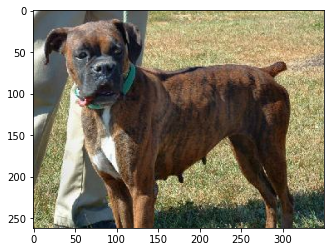

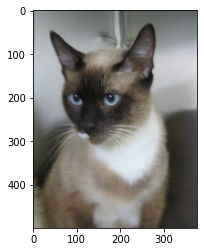

In [142]:
# Load rock_paper_scissors dataset
ds = tfds.load('cats_vs_dogs', as_supervised=True, split='train[:90%]')       # first 90% of the dataset
ds_test = tfds.load('cats_vs_dogs', as_supervised=True, split='train[-10%:]') # last 10% of the dataset
 
for image, label in ds.take(1):
  plt.figure(1)
  plt.imshow(image)
  my_test_image_dog = image
  print(image.shape, label)

for image, label in ds_test.take(1):
  plt.figure(2)
  plt.imshow(image)
  my_test_image_cat = image
  my_test_image_cat_label = label.numpy()
  print(image.shape, label)


(100, 100, 3) tf.Tensor(1, shape=(), dtype=int64)
(100, 100, 3) tf.Tensor(0, shape=(), dtype=int64)


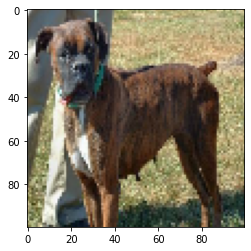

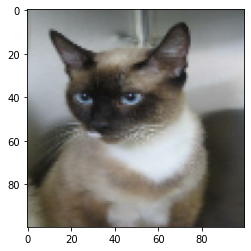

In [4]:
##### Mapping step:

# Normalize images
def normalize_img(image,label):
  """Normalizes images: uint8 -> float32."""
  return tf.cast(image, tf.float32) / 255. , label

# Resize images
def reduce_img(image,label):
  return tf.image.resize(image,[100,100]), label

# Apply normalization to each element of the training and test set
ds = ds.map(normalize_img)
ds_test = ds_test.map(normalize_img)


# Apply resize to each element of the training and test set
ds = ds.map(reduce_img)
ds_test = ds_test.map(reduce_img)

# Check reduced images
for image, label in ds.take(1):
  plt.figure(3)
  plt.imshow(image)
  print(image.shape, label)

# Check reduced images
for image, label in ds_test.take(1):
  plt.figure(4)
  plt.imshow(image)
  print(image.shape, label)

In [5]:
# Batch method vectorizes the data into batchs of N images (increases performance)
ds = ds.cache()
ds = ds.batch(128) 
#ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.cache()
ds_test = ds_test.batch(128)

In [6]:
# Build the model

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 100x100 with 3 color channels
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # Hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    # Final layer (classifier)
    tf.keras.layers.Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        1

In [7]:
# Compile model (i.e., configure it)
# Optimizer: generates new parameters for the functions to see if it can do better
# Loss: measures how good or bad the current epoch results are
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [113]:
# The Model.fit method adjusts the model parameters to minimize the loss:

history = model.fit(ds, batch_size = 128, shuffle=True, epochs=30, validation_data=ds_test)

Epoch 1/30
164/164 [==============================] - 6s 36ms/step - loss: 0.3271 - accuracy: 0.8589 - val_loss: 0.3642 - val_accuracy: 0.8465
Epoch 2/30
164/164 [==============================] - 6s 35ms/step - loss: 0.3179 - accuracy: 0.8622 - val_loss: 0.3457 - val_accuracy: 0.8478
Epoch 3/30
164/164 [==============================] - 6s 35ms/step - loss: 0.3047 - accuracy: 0.8677 - val_loss: 0.3640 - val_accuracy: 0.8426
Epoch 4/30
164/164 [==============================] - 6s 35ms/step - loss: 0.2941 - accuracy: 0.8718 - val_loss: 0.3515 - val_accuracy: 0.8521
Epoch 5/30
164/164 [==============================] - 6s 35ms/step - loss: 0.2776 - accuracy: 0.8803 - val_loss: 0.3430 - val_accuracy: 0.8564
Epoch 6/30
164/164 [==============================] - 6s 35ms/step - loss: 0.2598 - accuracy: 0.8880 - val_loss: 0.3589 - val_accuracy: 0.8508
Epoch 7/30
164/164 [==============================] - 6s 35ms/step - loss: 0.2486 - accuracy: 0.8943 - val_loss: 0.3571 - val_accuracy: 0.8547

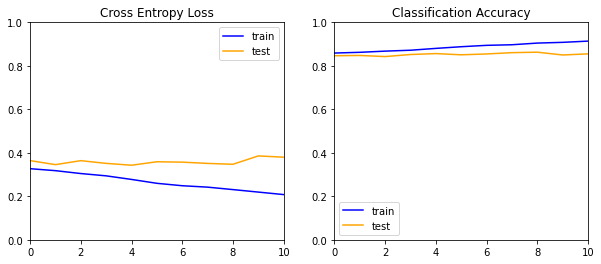

In [117]:
# plot loss
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].set_title('Cross Entropy Loss')
ax[0].plot(history.history['loss'], color='blue', label='train')
ax[0].plot(history.history['val_loss'], color='orange', label='test')
ax[0].set_xlim([0, 10])
ax[0].set_ylim([0, 1])
ax[0].legend()

# plot accuracy
ax[1].set_title('Classification Accuracy')
ax[1].plot(history.history['accuracy'], color='blue', label='train')
ax[1].plot(history.history['val_accuracy'], color='orange', label='test')
ax[1].set_xlim([0, 10])
ax[1].set_ylim([0, 1])
ax[1].legend()


# save plot to file
#filename = sys.argv[0].split('/')[-1]
#pyplot.savefig(filename + '_plot.png')
#pyplot.close()


In [118]:
# If we want the model to return a probability, you can wrap the trained model, and attach the softmax to it:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

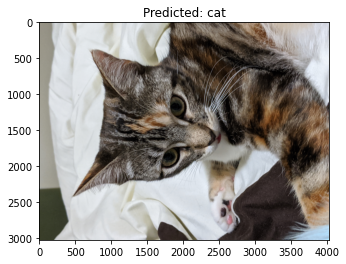

In [161]:
# Test it with a given image

# Load specific image
#image = Image.open("./trash/cat_photo.jpg").resize((100,100))
image = Image.open("./my_photos/chloe_photo.jpg")
#image = my_test_image_cat
mydata = np.asarray(image)
mydata = resize(mydata,(100,100))


# Convert to tensor
im_tensor = tf.convert_to_tensor(mydata, dtype=tf.float32)
im_tensor = tf.expand_dims(im_tensor, axis=0)

prediction_array = probability_model(im_tensor) # Shows the probability of being 0 (cat) and the probability of being 1 (dog)
predicted_label = np.argmax(prediction_array) # Extracts label with highest confidence

# Recall: cat => label 0, dog => label 1
labels = ['cat','dog']

plt.imshow(image)
plt.title("Predicted: {}".format(labels[predicted_label]));


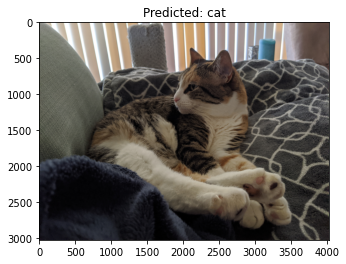

In [159]:
# Test it with a given image

# Load specific image
image = Image.open("./my_photos/kate_photo.jpg")
mydata = np.asarray(image)
mydata = resize(mydata,(100,100))

# Convert to tensor
im_tensor = tf.convert_to_tensor(mydata, dtype=tf.float32)
im_tensor = tf.expand_dims(im_tensor, axis=0)

prediction_array = probability_model(im_tensor) # Shows the probability of being 0 (cat) and the probability of being 1 (dog)
predicted_label = np.argmax(prediction_array) # Extracts label with highest confidence

plt.imshow(image)
plt.title("Predicted: {}".format(labels[predicted_label]));


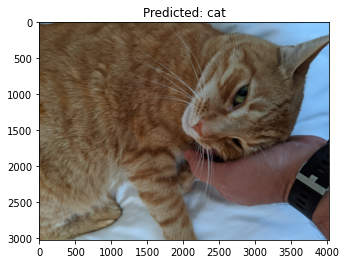

In [160]:
# Test it with a given image

# Load specific image
image = Image.open("./my_photos/leo_photo.jpg")
mydata = np.asarray(image)
mydata = resize(mydata,(100,100))


# Convert to tensor
im_tensor = tf.convert_to_tensor(mydata, dtype=tf.float32)
im_tensor = tf.expand_dims(im_tensor, axis=0)

prediction_array = probability_model(im_tensor) # Shows the probability of being 0 (cat) and the probability of being 1 (dog)
predicted_label = np.argmax(prediction_array) # Extracts label with highest confidence

# Recall: cat => label 0, dog => label 1
labels = ['cat','dog']

plt.imshow(image)
plt.title("Predicted: {}".format(labels[predicted_label]));
